*Flow Capacity Variable, Hierarchical Ward*

In [2]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt
import glob
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np
import openpyxl

calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Aggregates source capacities from all SPORE NetCDF files into a single DataFrame, with each row representing a SPORE configuration and columns representing technology capacities.

In [3]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_source = data['flow_cap'].to_dataframe().reset_index()
    
    # Filter out any "_to_" techs and drop NaN values in flow_cap
    data_source = data_source[~data_source['techs'].str.contains(r'_to_', regex=True)]
    data_source = data_source.dropna(subset=['flow_cap'])
    
    # Aggregate the source capacities by tech
    aggregated_flow_cap = data_source.groupby('techs')['flow_cap'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_flow_cap.set_index('techs')['flow_cap']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_flow_cap['techs']
aggregated_all = aggregated_matrix.copy()
aggregated_matrix = aggregated_matrix.drop(columns=['lost_load','import_power','export_power','demand_power','curtailment'])

# Show the resulting matrix
aggregated_matrix

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore
spore_5,0.021306,3998.989336,3675.952809,1263.934835,0.002485,485.076166,24359.004328,4756.987354,6956.888585
minons_spore_8,1.668140,5549.403476,1378.567905,2068.114857,0.167569,493.506789,24359.003173,4756.645760,6953.000001
minoff_spore_7,0.442854,4057.682306,4363.532005,1083.344938,0.045860,487.120474,24359.000491,4748.000922,6953.457081
maxpv_spore_3,0.003669,5411.830325,4289.607355,0.031734,0.000359,485.010454,41873.275417,4756.999069,6953.000081
maxbat_spore_3,211.449166,8960.788041,902.070283,0.008979,0.000106,485.003073,24359.000073,4756.998508,6953.000025
...,...,...,...,...,...,...,...,...,...
minpv_spore_4,4.783517,4971.355842,3124.248330,1178.944061,0.437834,507.644718,24359.000001,4757.152753,6954.577481
maxoff_spore_5,0.007640,6029.604812,2662.138660,0.056897,0.000637,485.020681,24359.001065,12423.648215,6953.000423
minbat_spore_1,0.000062,8215.482213,2638.025995,381.163716,5.734455,614.514479,24359.000286,4756.674389,6957.151391
maxbio_spore_10,16.806411,12000.000000,337.165500,83.532898,1.993511,522.006372,24359.000170,4754.232221,6953.307272


Standardizes the aggregated technology capacity data using `StandardScaler`.

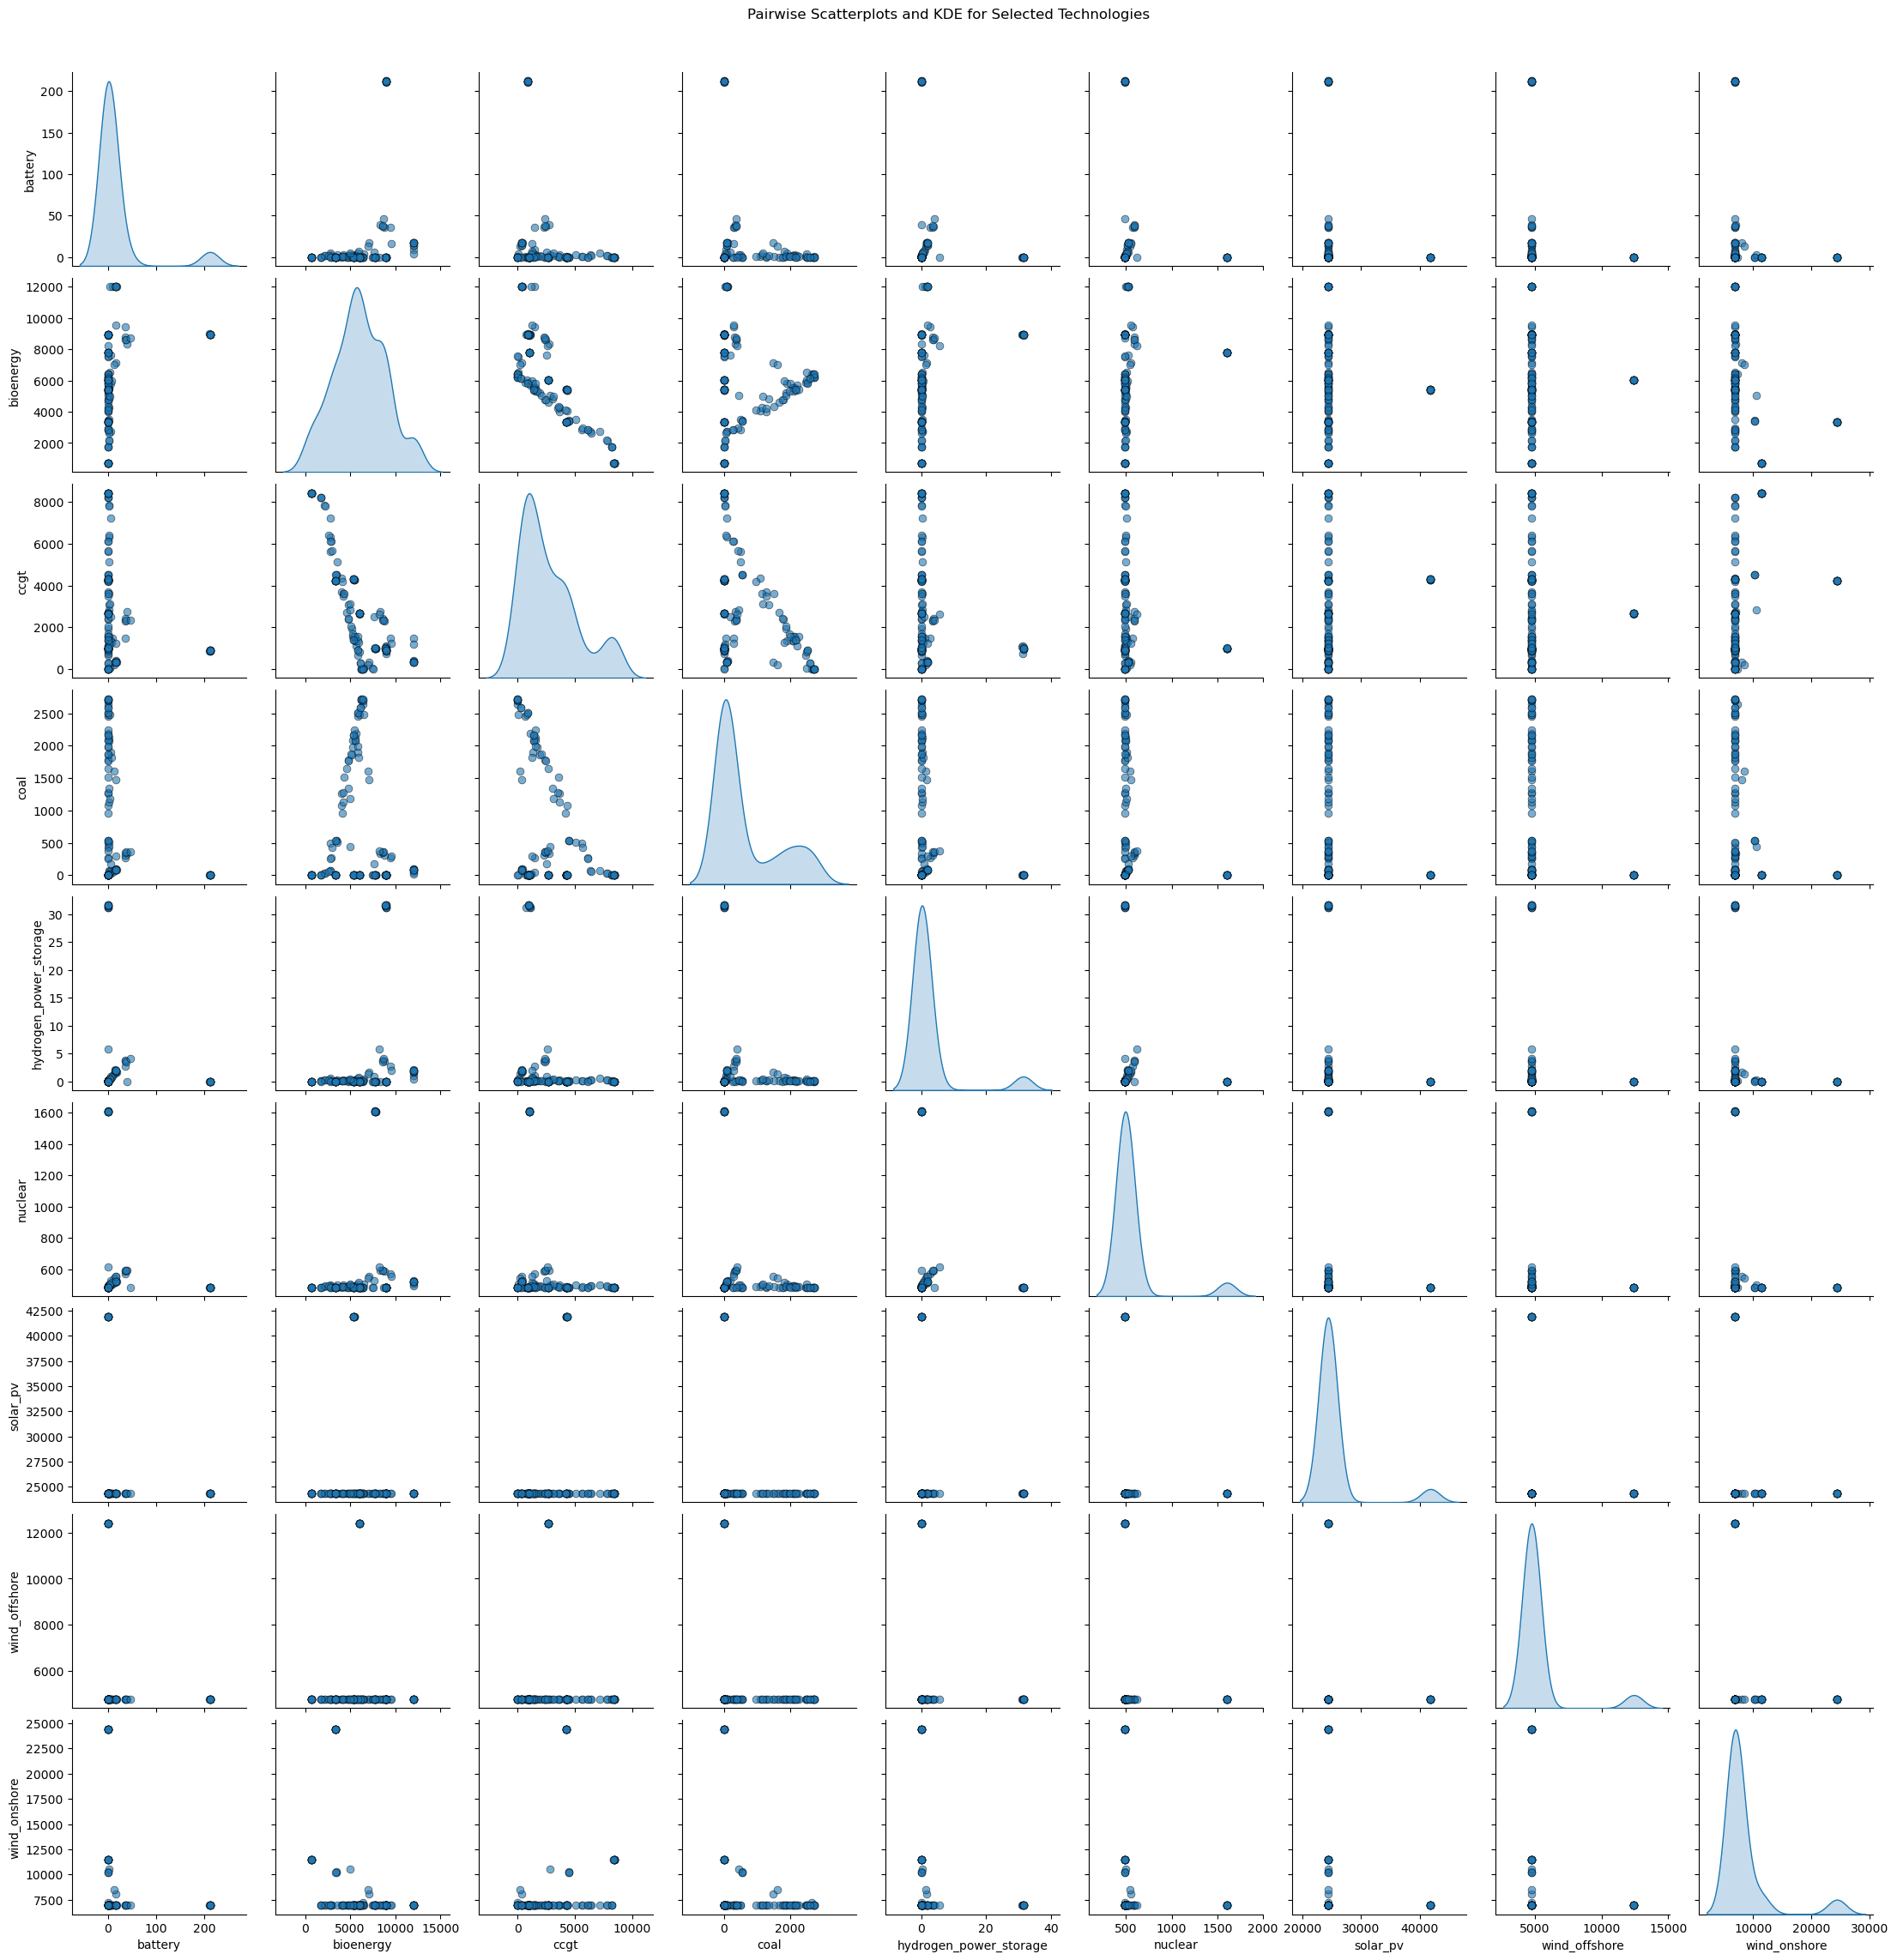

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# If the dataset is large, you may want to select only a subset of columns (features)
# For example, select a few key technologies:
features = ['battery', 'bioenergy', 'ccgt', 'coal', 'nuclear', 'solar_pv', 'wind_offshore', 'wind_onshore']

# Create the pairplot
sns.pairplot(aggregated_matrix[aggregated_matrix.columns], diag_kind='kde', plot_kws={'alpha':0.6, 's':40, 'edgecolor':'k'})

plt.suptitle('Pairwise Scatterplots and KDE for Selected Technologies', y=1.02)
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies

Computes the pairwise Euclidean distance matrix between all standardized SPORE configurations.

In [6]:
from scipy.spatial.distance import pdist, squareform

# Reduce dimensionality
pca = PCA(n_components=6)
X_pca = pca.fit_transform(matrix_scaled)

# Compute the pairwise Euclidean distance matrix
distance_matrix = pdist(X_pca, metric='euclidean')

# Convert the distance matrix into a square form (for plotting)
distance_matrix_square = squareform(distance_matrix)


Performs hierarchical clustering on the SPORE configurations using Ward’s method.

In [7]:
from scipy.cluster.hierarchy import linkage

# Perform hierarchical/agglomerative clustering using Ward's method
Z = linkage(distance_matrix, method='ward')  # `ward` minimizes the variance within clusters

Plots a dendrogram to visualize the hierarchical clustering of SPORE configurations.

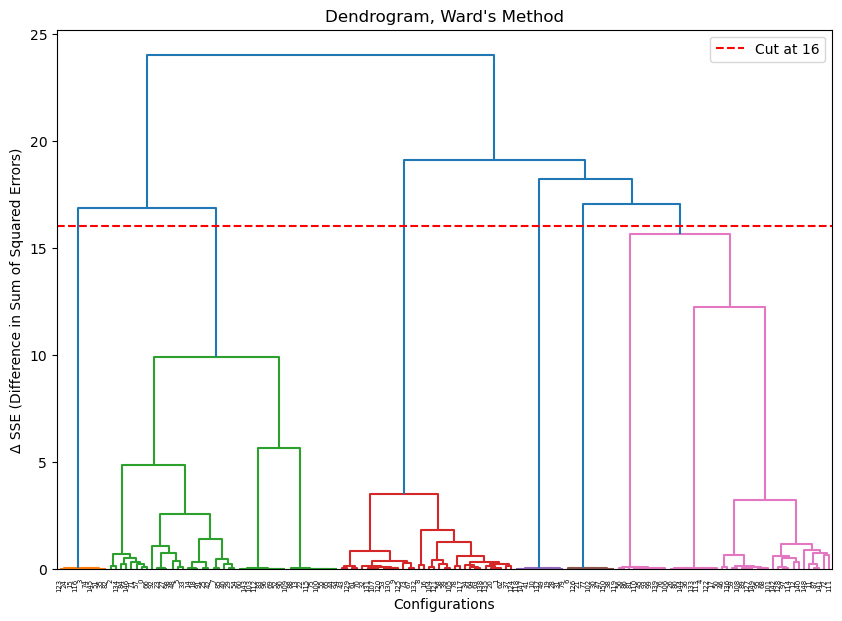

In [8]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram, Ward\'s Method')
plt.xlabel('Configurations')
plt.ylabel('Δ SSE (Difference in Sum of Squared Errors)')

plt.axhline(y=16, color='r', linestyle='--', label='Cut at 16')
plt.legend()

plt.show()


Cuts the dendrogram at a specified maximum distance to assign cluster labels to each SPORE configuration and adds these labels to the DataFrame.

In [9]:
from scipy.cluster.hierarchy import fcluster

# Define the maximum distance threshold (e.g., 50)
max_distance = 16
clusters = fcluster(Z, max_distance, criterion='distance')

# Add the cluster labels to the DataFrame
aggregated_matrix['Cluster_Hierarchical'] = clusters
aggregated_all['Cluster_Hierarchical'] = clusters


[2025-07-04 00:55:27] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3880908098.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



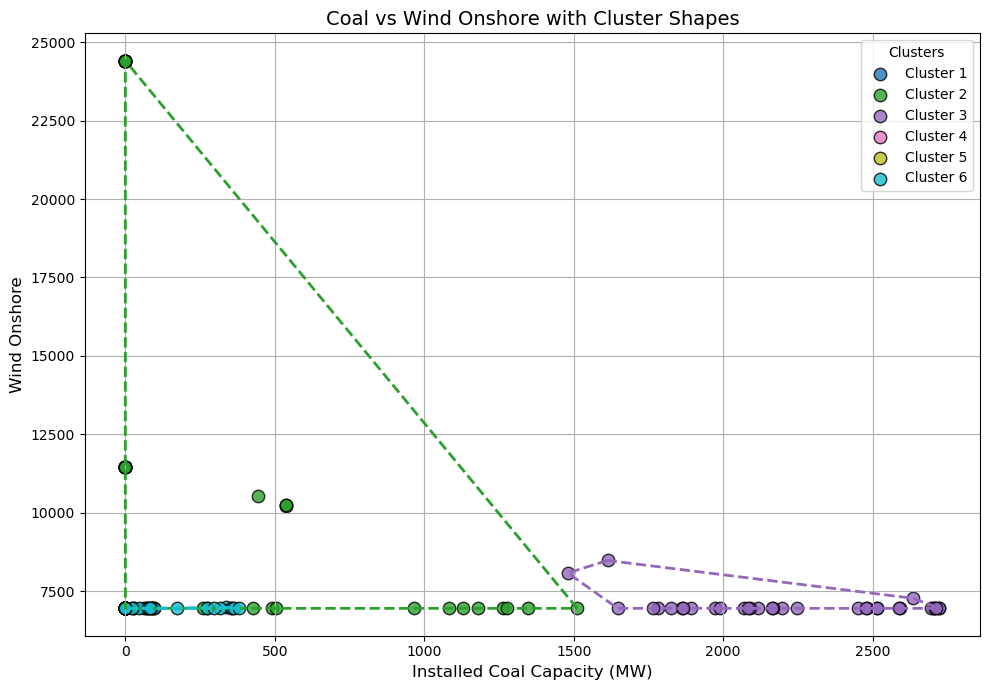

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['coal'].values
y = aggregated_all['wind_onshore'].values
cluster_labels = aggregated_all['Cluster_Hierarchical'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Coal Capacity (MW)', fontsize=12)
plt.ylabel('Wind Onshore', fontsize=12)
plt.title('Coal vs Wind Onshore with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-07-04 00:55:27] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/2192540910.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



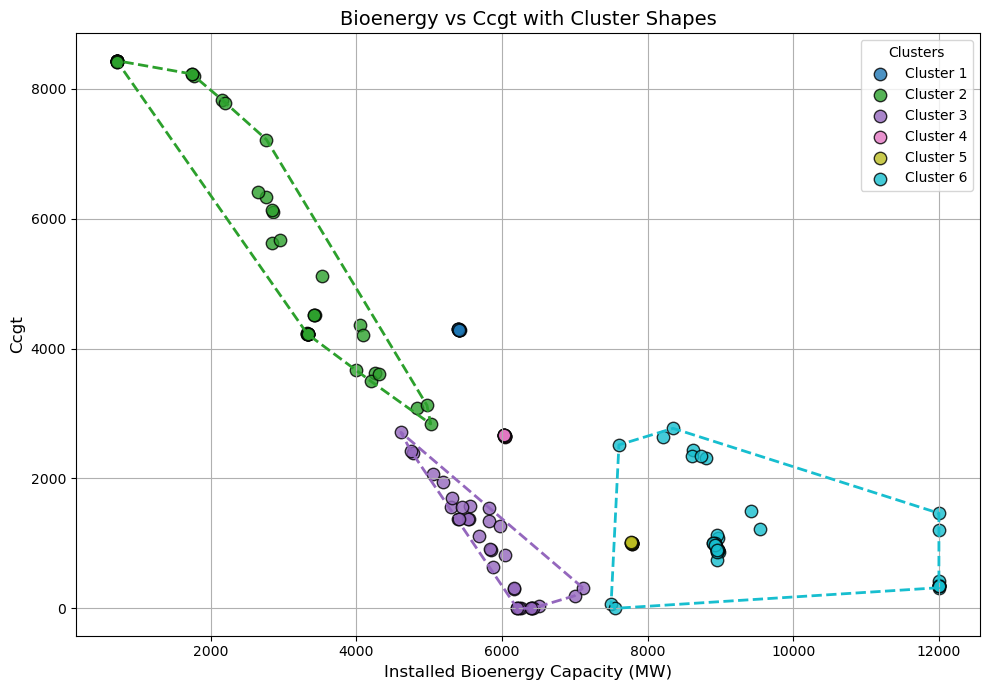

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['bioenergy'].values
y = aggregated_all['ccgt'].values
cluster_labels = aggregated_all['Cluster_Hierarchical'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Bioenergy Capacity (MW)', fontsize=12)
plt.ylabel('Ccgt', fontsize=12)
plt.title('Bioenergy vs Ccgt with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-07-04 00:55:27] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/2745727216.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



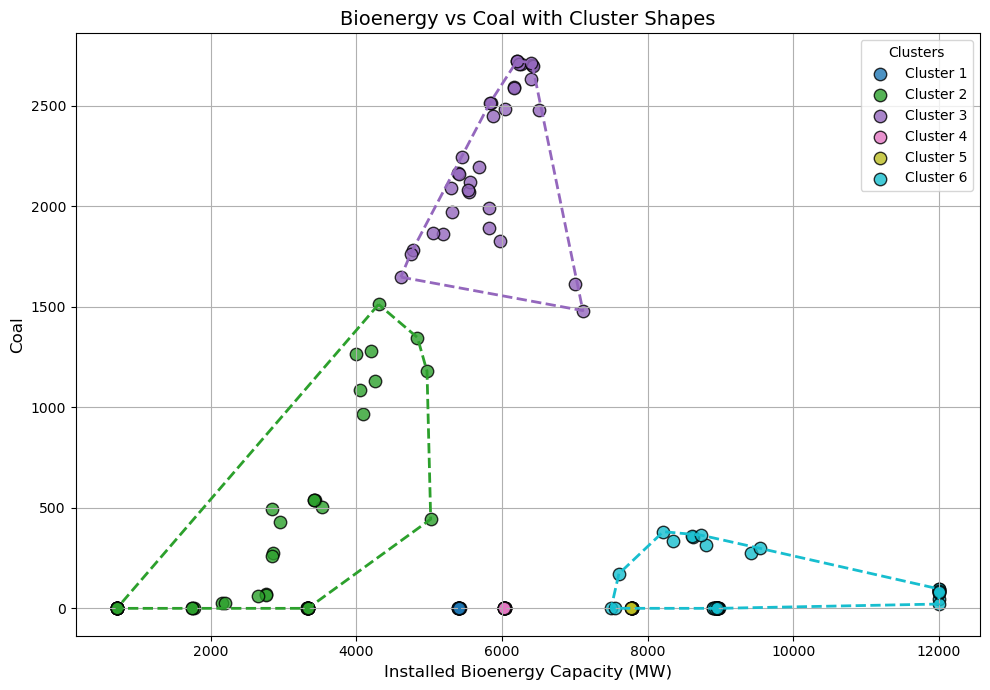

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['bioenergy'].values
y = aggregated_all['coal'].values
cluster_labels = aggregated_all['Cluster_Hierarchical'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Bioenergy Capacity (MW)', fontsize=12)
plt.ylabel('Coal', fontsize=12)
plt.title('Bioenergy vs Coal with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score

db_score = davies_bouldin_score(X_pca, clusters)
print(f"Davies-Bouldin score: {db_score:.3f}")
db_score_orig = davies_bouldin_score(matrix_scaled, clusters)
print(f"DB score on original space: {db_score_orig:.3f}")

# Clusters from PCA-based clustering
ch_score_pca = calinski_harabasz_score(X_pca, clusters)
print(f"CH score on PCA space: {ch_score_pca:.2f}")
ch_score_orig = calinski_harabasz_score(matrix_scaled, clusters)
print(f"CH score on original space: {ch_score_orig:.2f}")


score = silhouette_score(X_pca, clusters)
print(f'Silhouette score: {score:.3f}')
sh_score_orig = silhouette_score(matrix_scaled, clusters)
print(f"SC score on original space: {sh_score_orig:.3f}")

metrics_summary = {
    'Davies-Bouldin': db_score_orig,
    'Calinski-Harabasz': ch_score_orig,
    'Silhouette': sh_score_orig
}
metrics_summary = pd.DataFrame({
    'score': ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'value': [sh_score_orig, db_score_orig, ch_score_orig]
})

Davies-Bouldin score: 0.651
DB score on original space: 0.763
CH score on PCA space: 90.50
CH score on original space: 66.70
Silhouette score: 0.570
SC score on original space: 0.524


Extracts general SPORE categories from SPORE names, groups by cluster and category, and counts occurrences to show the distribution of SPORE types in each cluster.

In [14]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster_Hierarchical', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count['spore_main'] = cluster_spore_count[['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10']].sum(axis=1)
cluster_spore_count = cluster_spore_count.drop(columns=['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10'])

cluster_spore_count


spore_category_general,maxbat,maxbio,maxhtp,maxnuc,maxoff,maxons,maxpv,minbat,minbio,minhtp,minnuc,minoff,minons,minpv,spore_baseline,spore_main
Cluster_Hierarchical,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,10,0,3,10,3,3,5,5,5,0,1
3,0,0,0,0,0,0,0,6,0,6,6,4,4,4,0,4
4,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0
6,10,10,10,0,0,0,0,1,0,1,1,1,1,1,1,5


Calculates and displays the mean technology capacities for each identified cluster.

In [15]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster_Hierarchical').mean()

# Show the resulting cluster summary
cluster_summary

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore
Cluster_Hierarchical,,,,,,,,,
1,0.002650,5409.037680,4291.908197,0.023634,0.000257,485.007667,41872.921727,4756.999383,6953.000108
2,0.733385,2739.549178,5796.894545,311.736463,0.070362,488.114800,24359.001249,4755.954889,12134.518352
3,1.743303,5831.981845,976.193711,2236.554223,0.167580,492.646242,24359.001311,4755.805369,7040.688914
4,0.005355,6032.440710,2659.044989,0.040932,0.000470,485.014492,24359.000701,12422.020959,6953.000273
5,0.001425,7782.069499,1002.410272,0.013257,0.000138,1606.226907,24359.000136,4756.998190,6953.000042
6,59.956849,9542.545968,1081.833177,86.135758,8.502737,510.936479,24359.096063,4755.874914,6954.085123


Plots a bar chart showing the average technology capacities for each cluster.

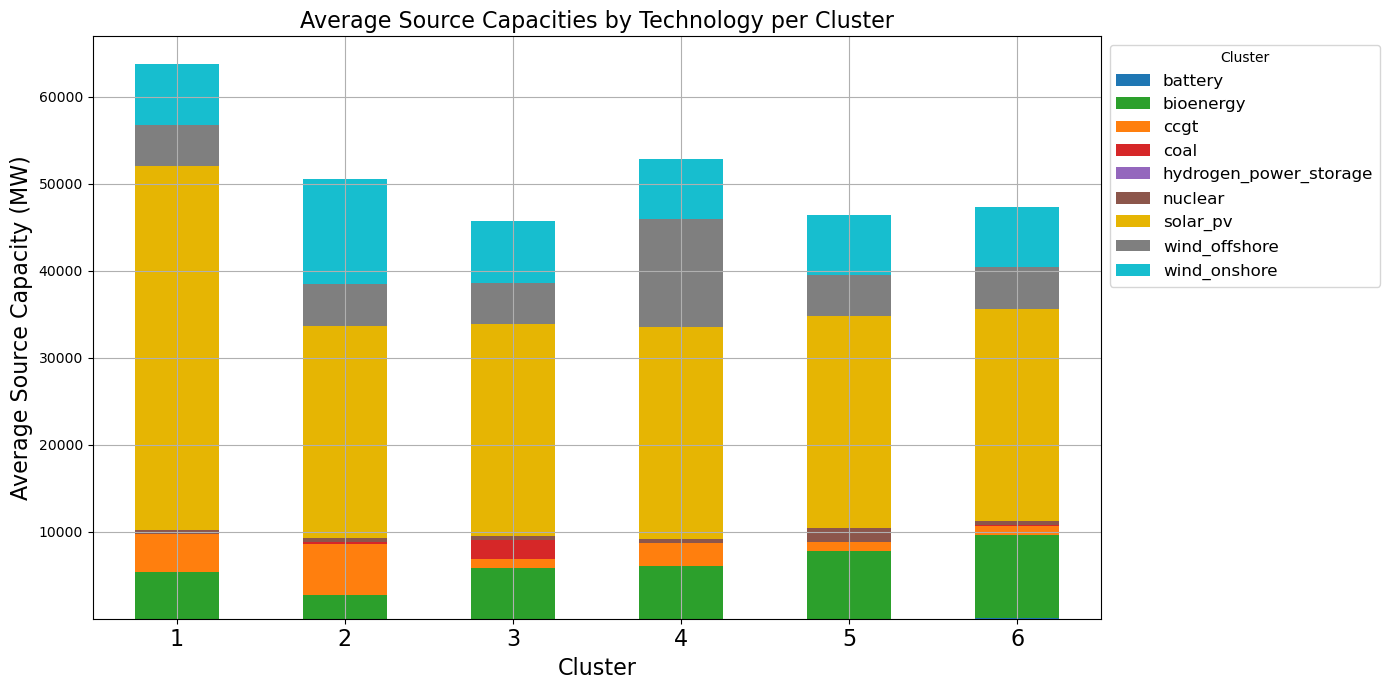

In [16]:
colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd', '#8c564b',"#e6b503", '#7f7f7f', '#17becf']
# Plot bar chart for each cluster
cluster_summary.plot(kind='bar', figsize=(14, 7), stacked=True, color=colors)

plt.title('Average Source Capacities by Technology per Cluster', size=16)
plt.xlabel('Cluster', size=16)
plt.ylabel('Average Source Capacity (MW)', size=16)
plt.xticks(rotation=0, size=16)
plt.legend(title='Cluster', fontsize=12, bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

Finds the representative configuration (closest to the centroid) for each cluster and plots their technology capacities.

Cluster 2 - Shape of cluster_configs: (45, 9)
Cluster 3 - Shape of cluster_configs: (34, 9)
Cluster 1 - Shape of cluster_configs: (10, 9)
Cluster 6 - Shape of cluster_configs: (42, 9)
Cluster 5 - Shape of cluster_configs: (10, 9)
Cluster 4 - Shape of cluster_configs: (10, 9)
Representative configurations: ['minhtp_spore_3', 'minoff_spore_6', 'maxpv_spore_4', 'spore_2', 'maxnuc_spore_5', 'maxoff_spore_7']


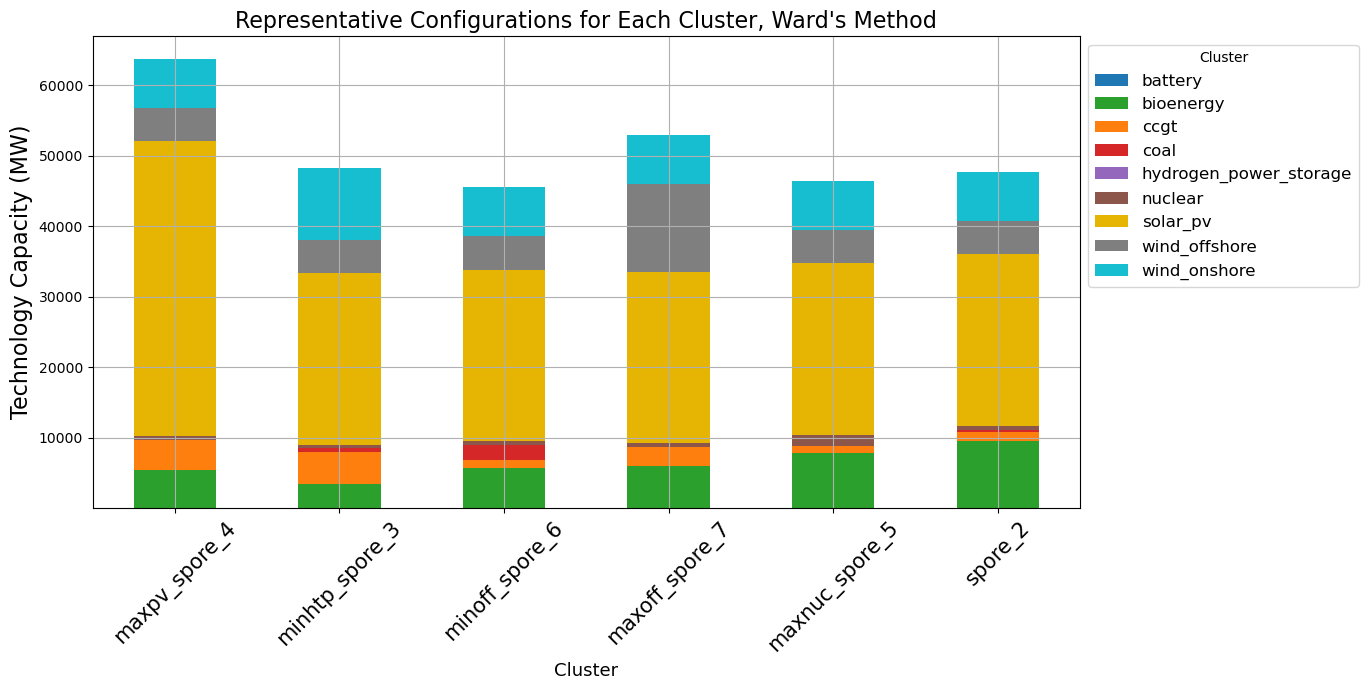

In [17]:
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns

# Assuming 'aggregated_matrix' is your DataFrame with the 'Cluster' and technology columns
# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster_Hierarchical').mean()

# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster_Hierarchical'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster_Hierarchical'] == cluster].drop(columns=['Cluster_Hierarchical'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs]

import seaborn as sns

colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd', '#8c564b',"#e6b503", '#7f7f7f', '#17becf']

df_representative_configs = df_representative_configs.sort_values(by='Cluster_Hierarchical', ascending=True)
# 4. Plot the representative configurations (one bar plot per cluster)
df_representative_configs.drop(columns=['Cluster_Hierarchical']).plot(kind='bar', figsize=(11, 7), stacked=True, color=colors)
# Add titles and labels
plt.title('Representative Configurations for Each Cluster, Ward\'s Method', size=16)
plt.xlabel('Cluster', size=13)
plt.ylabel('Technology Capacity (MW)', size=16)
plt.xticks(range(len(df_representative_configs)), labels=df_representative_configs.reset_index()['index'].values, rotation=45, size=15)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1., 1), fontsize=12, loc='upper left')
plt.grid(True)
plt.show()



[2025-07-04 00:55:27] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/4190534646.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))

[2025-07-04 00:55:27] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/4190534646.py:38: UserWarning: You passed a edgecolor/edgecolors ('gold') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(rep_x, rep_y, c='red', edgecolor='gold',

[2025-07-04 00:55:27] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/4190534646.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

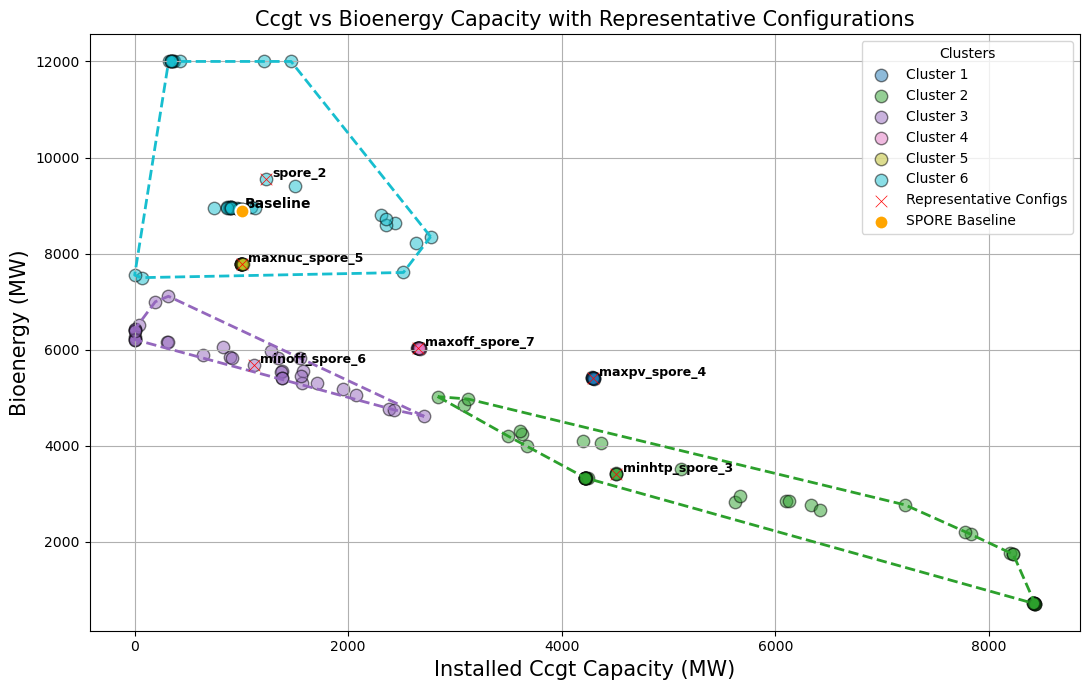

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# === Extract key data ===
x = aggregated_all['ccgt'].values
y = aggregated_all['bioenergy'].values
cluster_labels = aggregated_all['Cluster_Hierarchical'].values
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

# === Prepare representative config points ===
rep_x = aggregated_all.loc[representative_configs, 'ccgt']
rep_y = aggregated_all.loc[representative_configs, 'bioenergy']
rep_labels = list(representative_configs)  # These are the DataFrame indices

# === Plot all points with clusters and convex hulls ===
plt.figure(figsize=(11, 7))

for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.5)

    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# === Plot and annotate representative configs ===
plt.scatter(rep_x, rep_y, c='red', edgecolor='gold',
            s=70, marker='x', label='Representative Configs', zorder=10, linewidth=0.5)

# Add text labels near the stars
for i, label in enumerate(rep_labels):
    plt.text(rep_x[i] + 59, rep_y[i]+40, f"{label}",
             fontsize=9, weight='bold', color='black')
    
# === Plot baseline solution ===
baseline = aggregated_all[aggregated_all.index.str.contains("spore_baseline", case=False, na=False)].iloc[0]
baseline_x = baseline['ccgt']
baseline_y = baseline['bioenergy']

plt.scatter(baseline_x, baseline_y, c='orange', s=100, marker='o',
            label='SPORE Baseline', zorder=20, edgecolors='white', linewidths=1.5)
plt.text(baseline_x +30, baseline_y + 60, 'Baseline',
         fontsize=10, weight='bold', color='black')

# === Final touches ===
plt.xlabel('Installed Ccgt Capacity (MW)', fontsize=15)
plt.ylabel('Bioenergy (MW)', fontsize=15)
plt.title('Ccgt vs Bioenergy Capacity with Representative Configurations', fontsize=15)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()


[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3264314611.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))

[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3264314611.py:38: UserWarning: You passed a edgecolor/edgecolors ('gold') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(rep_x, rep_y, c='red', edgecolor='gold',

[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3264314611.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

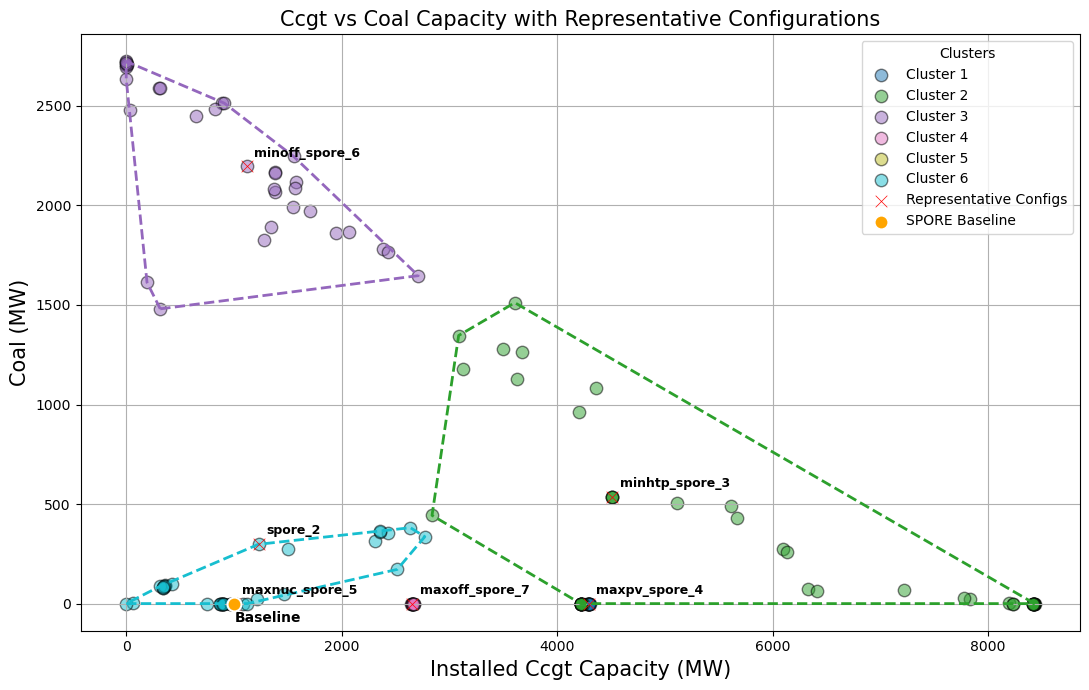

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# === Extract key data ===
x = aggregated_all['ccgt'].values
y = aggregated_all['coal'].values
cluster_labels = aggregated_all['Cluster_Hierarchical'].values
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

# === Prepare representative config points ===
rep_x = aggregated_all.loc[representative_configs, 'ccgt']
rep_y = aggregated_all.loc[representative_configs, 'coal']
rep_labels = list(representative_configs)  # These are the DataFrame indices

# === Plot all points with clusters and convex hulls ===
plt.figure(figsize=(11, 7))

for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.5)

    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# === Plot and annotate representative configs ===
plt.scatter(rep_x, rep_y, c='red', edgecolor='gold',
            s=70, marker='x', label='Representative Configs', zorder=10, linewidth=0.5)

# Add text labels near the stars
for i, label in enumerate(rep_labels):
    plt.text(rep_x[i] + 70, rep_y[i] + 50, f"{label}",
             fontsize=9, weight='bold', color='black')
    
# === Plot baseline solution ===
baseline = aggregated_all[aggregated_all.index.str.contains("spore_baseline", case=False, na=False)].iloc[0]
baseline_x = baseline['ccgt']
baseline_y = baseline['coal']

plt.scatter(baseline_x, baseline_y, c='orange', s=100, marker='o',
            label='SPORE Baseline', zorder=20, edgecolors='white', linewidths=1.5)
plt.text(baseline_x + 0.03, baseline_y -90, 'Baseline',
         fontsize=10, weight='bold', color='black')

# === Final touches ===
plt.xlabel('Installed Ccgt Capacity (MW)', fontsize=15)
plt.ylabel('Coal (MW)', fontsize=15)
plt.title('Ccgt vs Coal Capacity with Representative Configurations', fontsize=15)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()



[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/2513462474.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))

[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/2513462474.py:32: UserWarning: You passed a edgecolor/edgecolors ('gold') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(rep_x, rep_y, rep_z, c='red', edgecolor='gold',

[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/2513462474.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated

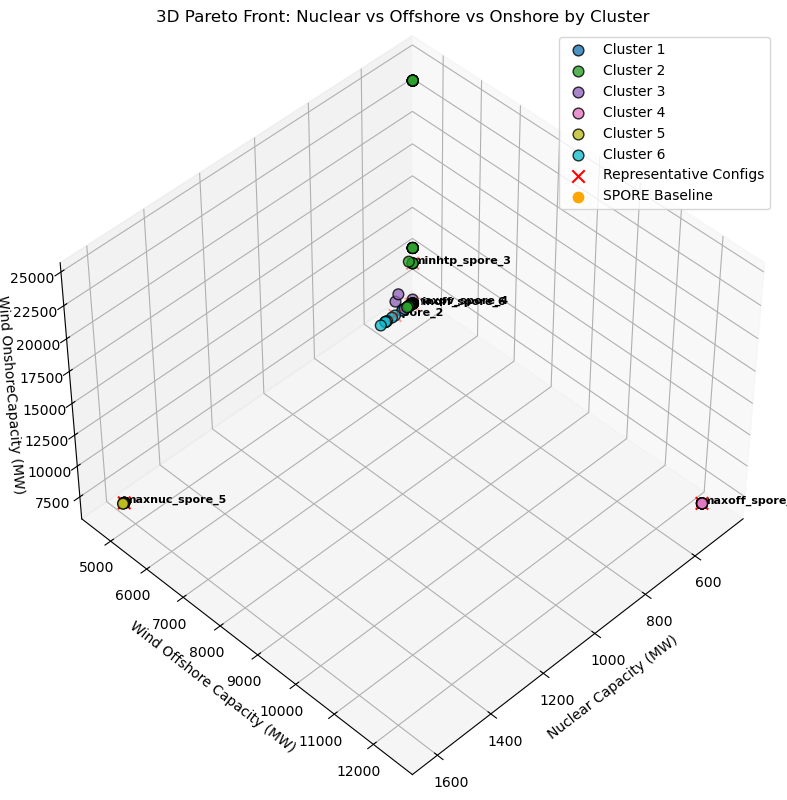

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Importa supporto 3D

# === Extract key data ===
x = aggregated_all['nuclear'].values
y = aggregated_all['wind_offshore'].values
z = aggregated_all['wind_onshore'].values
cluster_labels = aggregated_all['Cluster_Hierarchical'].values
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

# === Prepare representative config points ===
rep_x = aggregated_all.loc[representative_configs, 'nuclear']
rep_y = aggregated_all.loc[representative_configs, 'wind_offshore']
rep_z = aggregated_all.loc[representative_configs, 'wind_onshore']
rep_labels = list(representative_configs)

# === Prepare 3D plot ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# === Plot points by cluster ===
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    ax.scatter(x[mask], y[mask], z[mask],
               c=[cmap(i)], label=f'Cluster {cluster}',
               s=60, edgecolor='k', alpha=0.8)

# === Representative configs ===
ax.scatter(rep_x, rep_y, rep_z, c='red', edgecolor='gold',
           s=80, marker='x', label='Representative Configs', zorder=10)

for i, label in enumerate(rep_labels):
    ax.text(rep_x[i] + 0.1, rep_y[i], rep_z[i], f"{label}",
            fontsize=8, weight='bold', color='black')

# === Baseline ===
baseline = aggregated_all[aggregated_all.index.str.contains("spore_baseline", case=False, na=False)].iloc[0]
ax.scatter(baseline['nuclear'], baseline['wind_offshore'], baseline['wind_onshore'],
           c='orange', s=100, marker='o', edgecolors='white', linewidths=1.5,
           label='SPORE Baseline', zorder=20)
ax.text(baseline['bioenergy'] + 0.1, baseline['coal'], baseline['ccgt'],
        'Baseline', fontsize=10, weight='bold', color='black')

# === Labels and aesthetics ===
ax.set_xlabel('Nuclear Capacity (MW)')
ax.set_ylabel('Wind Offshore Capacity (MW)')
ax.set_zlabel('Wind OnshoreCapacity (MW)')
ax.set_title('3D Pareto Front: Nuclear vs Offshore vs Onshore by Cluster')
ax.legend()


ax.view_init(elev=45, azim=45)

plt.tight_layout()
plt.show()

[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3366417035.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))

[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3366417035.py:32: UserWarning: You passed a edgecolor/edgecolors ('gold') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(rep_x, rep_y, rep_z, c='red', edgecolor='gold',

[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3366417035.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated

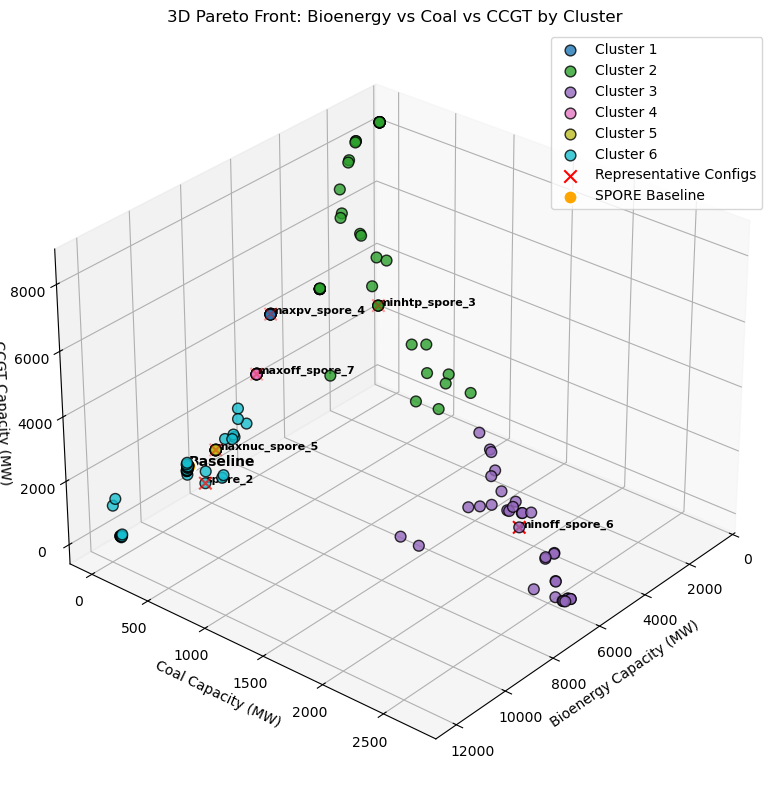

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Importa supporto 3D

# === Extract key data ===
x = aggregated_all['bioenergy'].values
y = aggregated_all['coal'].values
z = aggregated_all['ccgt'].values
cluster_labels = aggregated_all['Cluster_Hierarchical'].values
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

# === Prepare representative config points ===
rep_x = aggregated_all.loc[representative_configs, 'bioenergy']
rep_y = aggregated_all.loc[representative_configs, 'coal']
rep_z = aggregated_all.loc[representative_configs, 'ccgt']
rep_labels = list(representative_configs)

# === Prepare 3D plot ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# === Plot points by cluster ===
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    ax.scatter(x[mask], y[mask], z[mask],
               c=[cmap(i)], label=f'Cluster {cluster}',
               s=60, edgecolor='k', alpha=0.8)

# === Representative configs ===
ax.scatter(rep_x, rep_y, rep_z, c='red', edgecolor='gold',
           s=80, marker='x', label='Representative Configs', zorder=10)

for i, label in enumerate(rep_labels):
    ax.text(rep_x[i] + 0.1, rep_y[i], rep_z[i], f"{label}",
            fontsize=8, weight='bold', color='black')

# === Baseline ===
baseline = aggregated_all[aggregated_all.index.str.contains("spore_baseline", case=False, na=False)].iloc[0]
ax.scatter(baseline['bioenergy'], baseline['coal'], baseline['ccgt'],
           c='orange', s=100, marker='o', edgecolors='white', linewidths=1.5,
           label='SPORE Baseline', zorder=20)
ax.text(baseline['bioenergy'] + 0.1, baseline['coal'], baseline['ccgt'],
        'Baseline', fontsize=10, weight='bold', color='black')

# === Labels and aesthetics ===
ax.set_xlabel('Bioenergy Capacity (MW)')
ax.set_ylabel('Coal Capacity (MW)')
ax.set_zlabel('CCGT Capacity (MW)')
ax.set_title('3D Pareto Front: Bioenergy vs Coal vs CCGT by Cluster')
ax.legend()


ax.view_init(elev=30, azim=40)

plt.tight_layout()
plt.show()


[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3531437160.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))

[2025-07-04 00:55:28] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_4215/3531437160.py:38: UserWarning: You passed a edgecolor/edgecolors ('gold') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(rep_x, rep_y, c='red', edgecolor='gold',



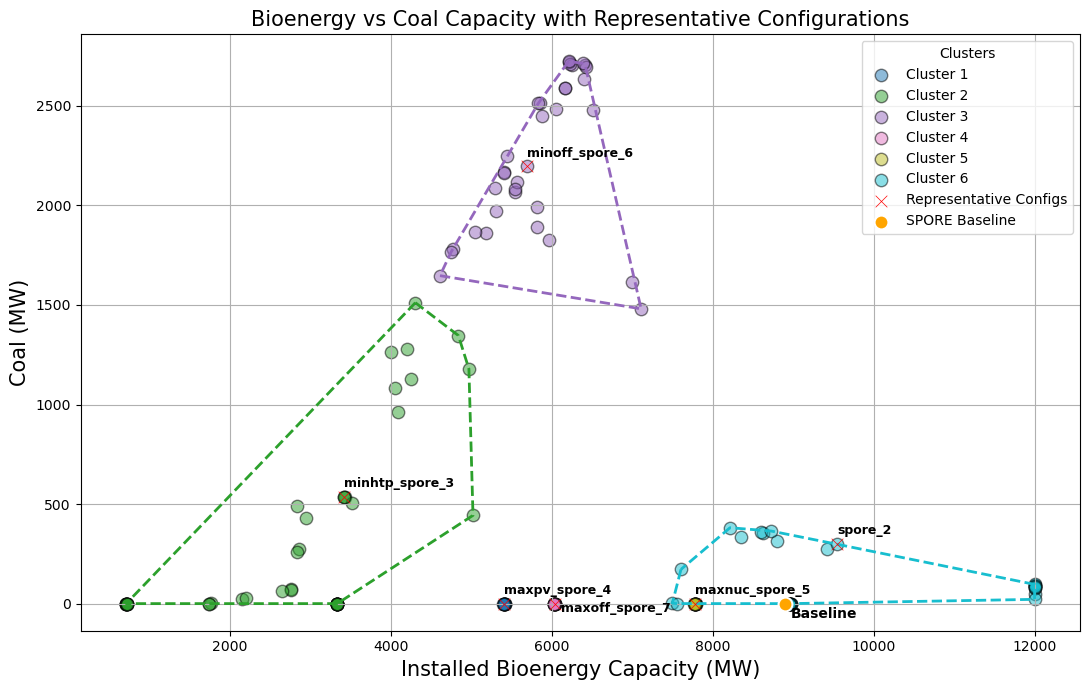

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# === Extract key data ===
x = aggregated_all['bioenergy'].values
y = aggregated_all['coal'].values
cluster_labels = aggregated_all['Cluster_Hierarchical'].values
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

# === Prepare representative config points ===
rep_x = aggregated_all.loc[representative_configs, 'bioenergy']
rep_y = aggregated_all.loc[representative_configs, 'coal']
rep_labels = list(representative_configs)  # These are the DataFrame indices

# === Plot all points with clusters and convex hulls ===
plt.figure(figsize=(11, 7))

for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.5)

    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# === Plot and annotate representative configs ===
plt.scatter(rep_x, rep_y, c='red', edgecolor='gold',
            s=70, marker='x', label='Representative Configs', zorder=10, linewidth=0.5)

# Offset personalizzati per label specifici
label_offsets = {
    "maxpv_spore_4": (0.03, 50),
    "maxoff_spore_7": (80, -40),
    # Aggiungi altri se necessario
}

for i, label in enumerate(rep_labels):
    dx, dy = label_offsets.get(label, (0.03, 50))  # default offset se non specificato
    plt.text(rep_x.iloc[i] + dx, rep_y.iloc[i] + dy,
             f"{label}", fontsize=9, weight='bold', color='black')

    

# === Plot baseline solution ===
baseline = aggregated_all[aggregated_all.index.str.contains("spore_baseline", case=False, na=False)].iloc[0]
baseline_x = baseline['bioenergy']
baseline_y = baseline['coal']

plt.scatter(baseline_x, baseline_y, c='orange', s=100, marker='o',
            label='SPORE Baseline', zorder=20, edgecolors='white', linewidths=1.5)
plt.text(baseline_x + 80, baseline_y-70, 'Baseline',
         fontsize=10, weight='bold', color='black')


# === Final touches ===
plt.xlabel('Installed Bioenergy Capacity (MW)', fontsize=15)
plt.ylabel('Coal (MW)', fontsize=15)
plt.title('Bioenergy vs Coal Capacity with Representative Configurations', fontsize=15)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()


Extracts and aggregates systemwide levelized cost and capacity factor metrics for each SPORE configuration from the NetCDF files.

In [23]:
import glob
import xarray as xr
import pandas as pd

# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the performance metrics for each SPORE
performance_metrics_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Extract systemwide levelized cost (LCOE)
    data_sys_LCOE = data['systemwide_levelised_cost'].to_dataframe().reset_index()
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['costs'] == 'monetary']  # Filter for monetary costs
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['techs'] != 'lost_load']  # Exclude 'lost_load'
    data_sys_LCOE = data_sys_LCOE[~data_sys_LCOE['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_LCOE = data_sys_LCOE.drop(columns=['costs', 'carriers'])  # Drop unnecessary columns
    data_sys_LCOE = data_sys_LCOE[(data_sys_LCOE['techs'] != 'curtailment')&(data_sys_LCOE['techs'] != 'demand_power')&(data_sys_LCOE['techs'] != 'export_power')] # Exclude 'curtailment'
    
    # Extract systemwide capacity factor
    data_sys_cap = data['systemwide_capacity_factor'].to_dataframe().reset_index()
    data_sys_cap = data_sys_cap[~data_sys_cap['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_cap = data_sys_cap.drop(columns=['carriers'])  # Drop unnecessary columns
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'lost_load') & (data_sys_cap['techs'] != 'curtailment')]
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'demand_power') & (data_sys_cap['techs'] != 'export_power')]  # Exclude 'demand_power' and 'export_power'
    
    # Extract the SPORE name from the file name (e.g., 'maxnuc_spore_1')
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    
    # Merge the data for the current SPORE (levelized cost and capacity factor)
    performance_metrics_df = pd.DataFrame({
        'systemwide_levelized_cost': data_sys_LCOE.set_index('techs')['systemwide_levelised_cost'],
        'systemwide_capacity_factor': data_sys_cap.set_index('techs')['systemwide_capacity_factor']
    })
    
    # Add the 'techs' column back to the DataFrame for proper indexing
    performance_metrics_df['techs'] = performance_metrics_df.index
    
    # Add the SPORE name as a column for identification
    performance_metrics_df['spore_name'] = spore_name
    
    # Append the performance metrics for this SPORE to the list
    performance_metrics_list.append(performance_metrics_df)

# Combine all performance metrics data into a single DataFrame (with each SPORE as a row)
performance_metrics_matrix = pd.concat(performance_metrics_list, axis=0)

# Reorganize the matrix with 'techs' as the index and 'systemwide_levelized_cost' and 'systemwide_capacity_factor' as columns
performance_metrics_matrix = performance_metrics_matrix.set_index(['spore_name', 'techs'])

# Show the resulting performance metrics matrix
performance_metrics_matrix # Display the first few rows of the matrix for verification


systemwide_levelized_cost  \
spore_name     techs                                               
spore_5        battery                                  0.781309   
               bioenergy                                0.048679   
               ccgt                                     0.059055   
               coal                                     0.074788   
               hydrogen_power_storage                  18.345907   
...                                                          ...   
maxnuc_spore_4 import_power                             0.100000   
               nuclear                                  0.114333   
               solar_pv                                 0.064183   
               wind_offshore                            0.071631   
               wind_onshore                             0.054183   

                                       systemwide_capacity_factor  
spore_name     techs                                               
spore_5        battery                                   0.454780  
               bioenergy                                 0.999650  
               ccgt                                      0.997822  
               coal                                      0.999422  
               hydrogen_power_storage                    0.192320  
...                                                           ...  
maxnuc_spore_4 import_power                              0.052493  
               nuclear                                   0.999999  
               solar_pv                                  0.123826  
               wind_offshore                             0.299165  
               wind_onshore                              0.264519  

[1510 rows x 2 columns]

Retrieves and displays the systemwide levelized cost and capacity factor for each cluster’s representative configuration.

In [24]:
# Initialize two lists to hold the levelized cost and capacity factor for each representative configuration
levelized_cost_list = []
capacity_factor_list = []

# Iterate over each representative configuration (row in df_representative_configs)
for config in df_representative_configs.index:
    spore_name = config  # SPORE name as 'techs' holds the SPORE name
    
    # Extract the systemwide levelized cost for each SPORE configuration
    levelized_cost = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_levelized_cost'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    capacity_factor = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_capacity_factor'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    
    # Append the results as rows in the respective lists
    levelized_cost_list.append(levelized_cost)
    capacity_factor_list.append(capacity_factor)

# Convert the lists into DataFrames
df_levelized_cost = pd.DataFrame(levelized_cost_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)
df_capacity_factor = pd.DataFrame(capacity_factor_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)

# Display the resulting DataFrames
print("Systemwide Levelized Cost Table:")
print(df_levelized_cost)
print("\nSystemwide Capacity Factor Table:")
print(df_capacity_factor)

Systemwide Levelized Cost Table:
techs            battery  bioenergy      ccgt      coal  \
maxpv_spore_4   0.776589   0.049792  0.073795  0.099947   
minhtp_spore_3  0.782989   0.048681  0.059950  0.074811   
minoff_spore_6  0.784484   0.048704  0.059162  0.074874   
maxoff_spore_7  0.769571   0.048793  0.081883  0.107869   
maxnuc_spore_5  0.770561   0.048711  0.085508  0.101161   
spore_2         1.311944   0.049379  0.081249  0.102567   

techs           hydrogen_power_storage  import_power   nuclear  solar_pv  \
maxpv_spore_4                18.341290           0.1  0.114334  0.063560   
minhtp_spore_3               94.228218           0.1  0.114346  0.064183   
minoff_spore_6               17.787546           0.1  0.114564  0.064183   
maxoff_spore_7               16.129596           0.1  0.114335  0.064183   
maxnuc_spore_5               15.135274           0.1  0.114333  0.064183   
spore_2                      34.215501           0.1  0.123002  0.064183   

techs           wind

Displays the DataFrame of systemwide levelized costs for representative configurations.

<Figure size 1400x700 with 0 Axes>

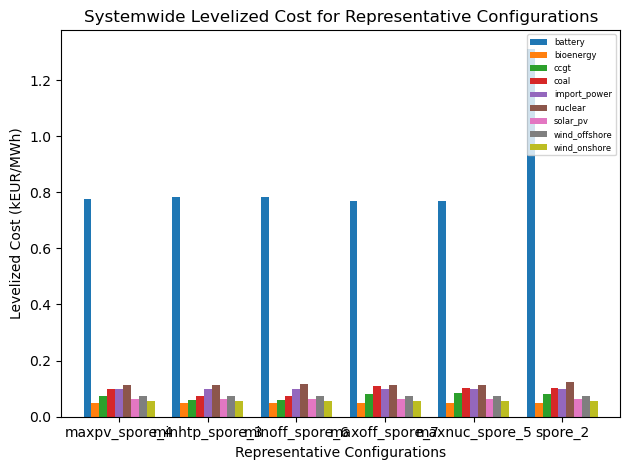

techs,battery,bioenergy,ccgt,coal,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
maxpv_spore_4,0.776589,0.049792,0.073795,0.099947,0.1,0.114334,0.063560,0.071631,0.054183
minhtp_spore_3,0.782989,0.048681,0.059950,0.074811,0.1,0.114346,0.064183,0.071632,0.054525
minoff_spore_6,0.784484,0.048704,0.059162,0.074874,0.1,0.114564,0.064183,0.071950,0.054184
maxoff_spore_7,0.769571,0.048793,0.081883,0.107869,0.1,0.114335,0.064183,0.071828,0.054183
maxnuc_spore_5,0.770561,0.048711,0.085508,0.101161,0.1,0.114333,0.064183,0.071631,0.054183
spore_2,1.311944,0.049379,0.081249,0.102567,0.1,0.123002,0.064183,0.071888,0.054185


In [25]:
plt.figure(figsize=(14, 7))
df_levelized_cost = df_levelized_cost.drop(columns=['hydrogen_power_storage'])
df_levelized_cost.plot(kind='bar', stacked=False, width=0.8)
plt.title('Systemwide Levelized Cost for Representative Configurations')
plt.xlabel('Representative Configurations')
plt.ylabel('Levelized Cost (kEUR/MWh)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(loc='upper right', prop={'size': 6})
plt.show()

df_levelized_cost

Displays the DataFrame of systemwide capacity factors for representative configurations.

<Figure size 1400x700 with 0 Axes>

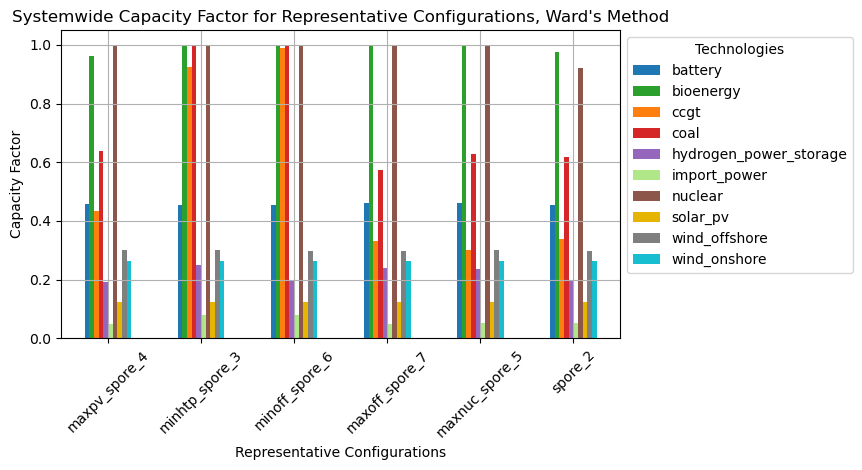

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
maxpv_spore_4,0.457491,0.961838,0.435253,0.639503,0.191254,0.048827,0.999993,0.125040,0.299164,0.264519
minhtp_spore_3,0.453791,0.999582,0.925220,0.998915,0.248081,0.079069,0.999874,0.123826,0.299159,0.262812
minoff_spore_6,0.452919,0.998763,0.988539,0.997506,0.194119,0.078253,0.997708,0.123826,0.297837,0.264515
maxoff_spore_7,0.461524,0.995664,0.332407,0.574367,0.238509,0.048821,0.999983,0.123826,0.298345,0.264519
maxnuc_spore_5,0.460972,0.998545,0.300580,0.628577,0.234395,0.052637,0.999999,0.123826,0.299165,0.264519
spore_2,0.455876,0.975555,0.338684,0.616381,0.196546,0.052216,0.920462,0.123826,0.298093,0.264512


In [27]:
plt.figure(figsize=(14, 7))
colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd', "#afe789", '#8c564b',"#e6b503", '#7f7f7f', '#17becf']
df_capacity_factor.plot(kind='bar', stacked=False, color=colors)
plt.title('Systemwide Capacity Factor for Representative Configurations, Ward\'s Method')
plt.xlabel('Representative Configurations')
plt.ylabel('Capacity Factor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Technologies', bbox_to_anchor=(1., 1), loc='upper left')
plt.grid(True)
plt.show()

df_capacity_factor

In [26]:
with pd.ExcelWriter('results/output_ward_2.xlsx', engine='openpyxl') as writer:
    df_capacity_factor.to_excel(writer, sheet_name='systemwide_capacity_factor', index=False)
    df_levelized_cost.to_excel(writer, sheet_name='systemwide_levelized_cost', index=False)
    cluster_spore_count.to_excel(writer, sheet_name='spore_count', index=True)
    cluster_summary.to_excel(writer, sheet_name='cluster_summary', index=True)
    df_representative_configs.to_excel(writer, sheet_name='representative_configs', index=True)
    metrics_summary.to_excel(writer, sheet_name='metrics_summary', index=False)